# Generating Zonal Statistics with a Custom Script
This notebook demonstrates how to generate zonal statistics using a custom Python script, with a focus on analyzing night light intensity across administrative regions in Rwanda. You will learn how to set up your workspace, import and prepare geospatial data, clip global raster datasets to a country boundary, and visualize the results. The workflow includes using custom utilities for zonal statistics, merging results with administrative boundaries, and saving the outputs for further analysis. This hands-on approach provides practical experience with geospatial data processing, raster analysis, and the integration of Python geospatial libraries such as geopandas and rasterio.

**Zonal statistics** are summary statistics (such as mean, sum, median, minimum, or maximum) calculated for values of a raster dataset within the boundaries of defined zones, such as polygons representing administrative regions or land cover types.


## Setup and Imports

### Required Packages

In [1]:
import sys
from pathlib import Path
import os
import pandas as pd
import numpy as np
import geopandas as gp
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import warnings
warnings.filterwarnings('ignore')

### Workspace Directory Setup

In [2]:
DIR_WORKSPACE = Path.cwd().parents[1]
DIR_DATA = DIR_WORKSPACE / "data"
DIR_SRC = DIR_WORKSPACE / "src"

In [ ]:
DIR_SRC

### Import Custom Python Script

In [3]:
# Add src directory to path to import our custom script
sys.path.append(str(DIR_SRC))


In [4]:
# We can now import our custom package
# There are cleaner ways to handle local imports but this works for now
from spatial_utils.zonal_stats import ZonalStatistics

### Input Data Files 
For the night lights file, please make sure you unzip it first. 

In [5]:
# ==========================================
# FILE PATHS
# ===========================================

# Unzipped night lights raster file with "tif" extension
FILE_NTL = DIR_DATA / "ntl/VNL_npp_2024_global_vcmslcfg_v2_c202502261200.average_masked.dat.tif"

# Shapefile with cell level (admin region level 4) boundaries 
FILE_SHP_ADM4 = DIR_DATA / "geospatial/pop-demo-infra/adm4-pop-buildings.shp"

# Shapefile with national boundaries (admin region level 0)
FILE_SHP_ADM0 = DIR_DATA / "geospatial/adm-bounds/geoBoundaries-RWA-ADM0-all/geoBoundaries-RWA-ADM0.shp"

## Zonal Statistics Analysis

### Clip Global Raster to Rwanda 
To make the raster file smaller and more manageable, we will clip (cut) it to the boundary of Rwanda. This step extracts only the portion of the raster that falls within Rwanda’s borders, reducing file size and improving processing efficiency.

In [6]:
def clip_raster_to_boundary(input_raster_path, boundary_gdf, output_path):
    """
    Clip a global raster to a country boundary
    
    Parameters:
    -----------
    input_raster_path : str
        Path to input raster file
    boundary_gdf : geopandas.GeoDataFrame
        Boundary for clipping
    output_path : str
        Path for output clipped raster
    
    Returns:
    --------
    str : Path to clipped raster
    """
    print(f"Clipping global raster to Rwanda boundary...")
    
    with rasterio.open(input_raster_path) as src:
        print(f"Original raster info:")
        print(f"  - Shape: {src.width} x {src.height}")
        print(f"  - CRS: {src.crs}")
        print(f"  - Bounds: {src.bounds}")
        print(f"  - Resolution: {src.res}")
        
        # Reproject boundary to match raster CRS if needed
        if boundary_gdf.crs != src.crs:
            print(f"Reprojecting boundary from {boundary_gdf.crs} to {src.crs}")
            boundary_gdf = boundary_gdf.to_crs(src.crs)
        
        # Clip raster
        clipped_data, clipped_transform = mask(
            src, 
            boundary_gdf.geometry, 
            crop=True,
            nodata=src.nodata
        )
        
        # Update metadata
        clipped_meta = src.meta.copy()
        clipped_meta.update({
            "driver": "GTiff",
            "height": clipped_data.shape[1],
            "width": clipped_data.shape[2],
            "transform": clipped_transform
        })
        
        # Create output directory if needed
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        
        # Write clipped raster
        with rasterio.open(output_path, "w", **clipped_meta) as dest:
            dest.write(clipped_data)
        
        print(f"✓ Clipped raster saved to: {output_path}")
        print(f"Clipped raster info:")
        print(f"  - Shape: {clipped_data.shape[2]} x {clipped_data.shape[1]}")
        print(f"  - Data range: {np.nanmin(clipped_data)} to {np.nanmax(clipped_data)}")
        
    return output_path

In [7]:
# =============================================
# CLIP THE GLOBAL RASTER TO RWANDA
# ===============================================

# Specify output clipped raster file
clipped_raster_path = DIR_DATA / "ntl/rwanda_2024_ntl.tif"

# Load level 0 boundaries in a GeoDataframe
gdf_adm0 = gp.read_file(FILE_SHP_ADM0)


# Call the clip raster function which utilises rasterio package
rwanda_raster_path = clip_raster_to_boundary(
    FILE_NTL, 
    gdf_adm0, 
    clipped_raster_path
)


Clipping global raster to Rwanda boundary...
Original raster info:
  - Shape: 86401 x 33601
  - CRS: EPSG:4326
  - Bounds: BoundingBox(left=-180.00208333335, bottom=-65.00208445335001, right=180.00208621335, top=75.00208333335)
  - Resolution: (0.0041666667, 0.0041666667)
✓ Clipped raster saved to: /home/kir2351763/RRA/other trainings/DSCBI/nightlight-analysis-alleluiaMireilleKirezi/data/ntl/rwanda_2024_ntl.tif
Clipped raster info:
  - Shape: 490 x 431
  - Data range: -1.5 to 103.27957153320312


### Visualize Clipped Raster

Text(838.7926460415241, 0.5, 'Latitude')

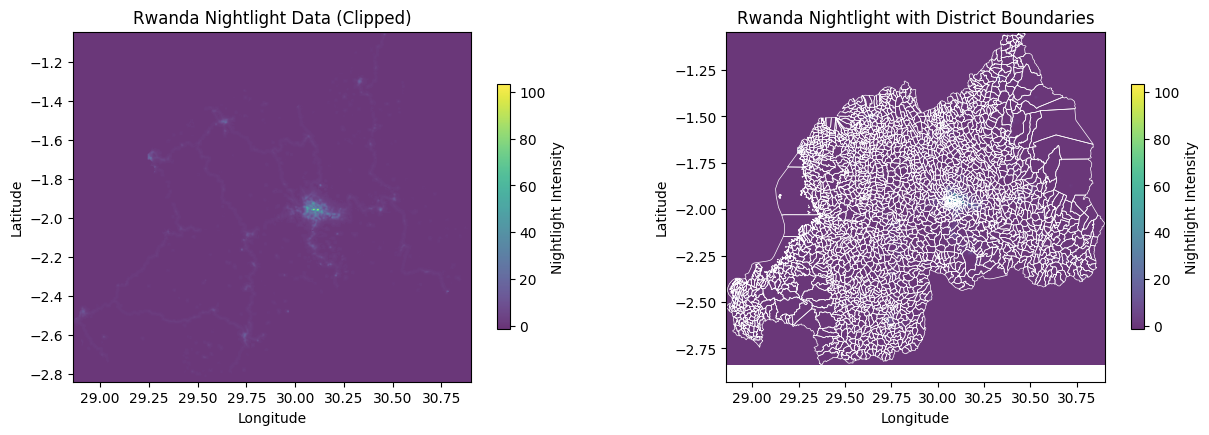

In [8]:
# =========================================
# LOAD AND VISUALIZE THE CLIPPED RASTER
# =========================================

# Load cell boundaries
gdf_adm4 = gp.read_file(FILE_SHP_ADM4)

with rasterio.open(rwanda_raster_path) as src:
    rwanda_nightlight = src.read(1)
    rwanda_extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

# Create visualization
plt.figure(figsize=(15, 10))

# Plot 1: Clipped raster
plt.subplot(2, 2, 1)
plt.imshow(rwanda_nightlight, extent=rwanda_extent, cmap='viridis', alpha=0.8)
plt.colorbar(label='Nightlight Intensity', shrink=0.7)
plt.title('Rwanda Nightlight Data (Clipped)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Plot 2: Raster with district boundaries
plt.subplot(2, 2, 2)
plt.imshow(rwanda_nightlight, extent=rwanda_extent, cmap='viridis', alpha=0.8)
rwanda_districts_plot = gdf_adm4.to_crs(gdf_adm0.crs) if gdf_adm4.crs != gdf_adm0.crs else gdf_adm4
rwanda_districts_plot.boundary.plot(ax=plt.gca(), color='white', linewidth=0.5)
plt.colorbar(label='Nightlight Intensity', shrink=0.7)
plt.title('Rwanda Nightlight with District Boundaries')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

### Generate Cell Level Zonal Statistics

In [9]:
# ===================================================
# GENERATING ZONAL STATISTICS WITH A CUSTOM SCRIPT
# ===================================================

# Create ZonalStatistics object using the clipped Rwanda data with
# the following args
# 1. Path of clipped night lights raster/image: rwanda_raster_path
# 2. Path of administrative boundaries shapefile: FILE_SHP_ADM4
# 3. Administrative level: 4

admin_level = "cell_id"

zs = ZonalStatistics(rwanda_raster_path, FILE_SHP_ADM4, admin_level)


In [10]:
# Load the data (this will print information about the datasets)
zs.load_data()


✓ Loaded raster: /home/kir2351763/RRA/other trainings/DSCBI/nightlight-analysis-alleluiaMireilleKirezi/data/ntl/rwanda_2024_ntl.tif
  - Shape: 490 x 431
  - CRS: EPSG:4326
  - Bands: 1
✓ Loaded shapefile: /home/kir2351763/RRA/other trainings/DSCBI/nightlight-analysis-alleluiaMireilleKirezi/data/geospatial/pop-demo-infra/adm4-pop-buildings.shp
  - Features: 2169
  - CRS: EPSG:4326
  - Columns: ['cell_id', 'province_n', 'district_n', 'sector_nam', 'cell_name', 'elderly_60', 'general_20', 'children_u', 'youth_15_2', 'men_2020', 'women_2020', 'building_c', 'geometry']


In [11]:
# =======================================
# DEFINE WHICH STATISTICS TO CALCULATE
# =======================================
stats_to_calculate = ['mean', 'median', 'count', "sum"]

print(f"Calculating statistics: {stats_to_calculate}")
print("This may take a few minutes depending on data size...")

# Calculate statistics
df_stats = zs.calculate_statistics(stats_to_calculate)

# Display results
print(f"\nAnalysis complete! Results shape: {df_stats.shape}")
display(df_stats.head(10))

Calculating statistics: ['mean', 'median', 'count', 'sum']
This may take a few minutes depending on data size...

Calculating statistics for 2169 features...
Statistics to calculate: mean, median, count, sum
  Processed 216/2169 features (10.0%)
  Processed 432/2169 features (19.9%)
  Processed 648/2169 features (29.9%)
  Processed 864/2169 features (39.8%)
  Processed 1080/2169 features (49.8%)
  Processed 1296/2169 features (59.8%)
  Processed 1512/2169 features (69.7%)
  Processed 1728/2169 features (79.7%)
  Processed 1944/2169 features (89.6%)
  Processed 2160/2169 features (99.6%)
✓ Completed zonal statistics calculation

Analysis complete! Results shape: (2169, 7)


,admin_name,admin_level,feature_id,mean,median,count,sum
0,RWA.1.1.1.1_1,cell_id,0,0.000000,0.0,66,0.000000
1,RWA.1.1.1.2_1,cell_id,1,0.000000,0.0,64,0.000000
2,RWA.1.1.1.3_1,cell_id,2,0.000000,0.0,55,0.000000
3,RWA.1.1.1.4_1,cell_id,3,0.000000,0.0,120,0.000000
4,RWA.1.1.2.1_1,cell_id,4,0.013441,0.0,144,1.935569
5,RWA.1.1.2.2_1,cell_id,5,0.257306,0.0,121,31.134054
6,RWA.1.1.2.3_1,cell_id,6,0.000000,0.0,110,0.000000
7,RWA.1.1.2.4_1,cell_id,7,0.003249,0.0,144,0.467896
8,RWA.1.1.2.5_1,cell_id,8,0.170577,0.0,110,18.763454
9,RWA.1.1.3.1_1,cell_id,9,0.000000,0.0,66,0.000000


In [12]:
# ==================================================
# SAVE RESULTS
# ==================================================

# Ensure we grab region names from original shapefile
cols2keep = ['cell_id', 'province_n', 'district_n', 'sector_nam', 'cell_name']
df_stats2 = df_stats.merge(gdf_adm4[cols2keep], left_on="admin_name", right_on='cell_id', how='left')

# Save results with the following columns
cols2keep = ['province_n', 'district_n', 'sector_nam',  'cell_name', 'mean', 'median', 'count',
       'sum']

df_stats2[cols2keep].to_csv(DIR_DATA / "ntl/rw-adm4-ntl-stats.csv", index=False)

In [13]:
## Report on Cells with Largest Night Light Values
largest_cells = df_stats2.nlargest(10, 'mean')
print("Cells with the largest night light values:")
display(largest_cells)

Cells with the largest night light values:


,admin_name,admin_level,feature_id,mean,median,count,sum,cell_id,province_n,district_n,sector_nam,cell_name
2042,RWA.5.1.8.3_1,cell_id,2042,22.040318,0.000000,25,551.007935,RWA.5.1.8.3_1,UmujyiwaKigali,Gasabo,Kimihurura,Rugando
2066,RWA.5.1.13.4_1,cell_id,2066,18.456652,0.000000,24,442.959656,RWA.5.1.13.4_1,UmujyiwaKigali,Gasabo,Remera,RukiriIi
2121,RWA.5.2.10.3_1,cell_id,2121,15.426421,0.000000,35,539.924744,RWA.5.2.10.3_1,UmujyiwaKigali,Kicukiro,Nyarugunga,Rwimbogo
2163,RWA.5.3.9.3_1,cell_id,2163,14.778305,0.000000,48,709.358643,RWA.5.3.9.3_1,UmujyiwaKigali,Nyarugenge,Nyarugenge,Kiyovu
2118,RWA.5.2.9.3_1,cell_id,2118,13.693196,0.000000,12,164.318359,RWA.5.2.9.3_1,UmujyiwaKigali,Kicukiro,Niboye,Nyakabanda
2063,RWA.5.1.13.1_1,cell_id,2063,13.375796,0.000000,18,240.764328,RWA.5.1.13.1_1,UmujyiwaKigali,Gasabo,Remera,Nyabisindu
2164,RWA.5.3.9.4_1,cell_id,2164,13.201833,12.788012,4,52.807331,RWA.5.3.9.4_1,UmujyiwaKigali,Nyarugenge,Nyarugenge,Rwampara
2037,RWA.5.1.7.1_1,cell_id,2037,12.877314,0.000000,30,386.319397,RWA.5.1.7.1_1,UmujyiwaKigali,Gasabo,Kacyiru,Kamatamu
2161,RWA.5.3.9.1_1,cell_id,2161,12.313789,0.000000,6,73.882736,RWA.5.3.9.1_1,UmujyiwaKigali,Nyarugenge,Nyarugenge,Agatare
2046,RWA.5.1.10.1_1,cell_id,2046,11.792180,0.000000,56,660.362061,RWA.5.1.10.1_1,UmujyiwaKigali,Gasabo,Kinyinya,Gacuriro
